In [1]:
from auto_matcher.semantic.matcher import EmbeddingMatching, SBertMatching
from auto_matcher.evaluation.evaluation_module import Evaluator
from auto_matcher.utils import normalise_df, find_optimum_cutoff, reduce_and_add_match
from pathlib import Path
import pandas as pd
from loguru import logger as LOGGER
import numpy as np
from pprint import pprint

ROOT_DIR = Path("/Users/i0954/projects/open_source/dissertation/")


def load_data():
    # 1. Load Historical Data
    df_history = pd.read_csv(
        ROOT_DIR / "historical_data/MIMIC_to_OMOP_Mapping.csv"
    ).fillna("None")
    df_history = normalise_df(df_history)

    # 2. Load Target Schema
    df_target = pd.read_csv(ROOT_DIR / "historical_data/target_schema_OMOP.csv")[
        ["TableName", "ColumnName"]
    ].fillna("none")
    df_target.columns = ["target_table", "target_column"]
    df_target = normalise_df(df_target)

    LOGGER.success("Data load completed")
    return df_history, df_target


def filter_results_embed(df_pred, df_history):
    df_pred["target_table"] = df_pred["target_table_column_pred"].apply(
        lambda x: x.split(" : ")[0]
    )
    df_pred["target_column"] = df_pred["target_table_column_pred"].apply(
        lambda x: x.split(" : ")[1]
    )
    filter_cols = [
        "source_table",
        "source_column",
        "target_table",
        "target_column",
        "confidence_score",
    ]
    best_cutoff, best_metrics = find_optimum_cutoff(df_pred[filter_cols], df_history)
    LOGGER.success(
        f"""
                   Best Cutoff:{round(best_cutoff,3)} 
                   and best Metrics are:
                    1. Precision: {best_metrics[0]} 
                    2. Accuracy [column]: {best_metrics[1]} 
                    3. Accuracy [gross]: {best_metrics[2]} 
                   """
    )
    df_pred = df_pred[filter_cols][df_pred["confidence_score"] >= best_cutoff]
    df_match = df_history.merge(
        df_pred,
        on=["source_table", "source_column"],
        how="left",
        suffixes=("_true", "_pred"),
    ).fillna("none")
    match_col_order = [
        "source_table",
        "source_column",
        "target_table_true",
        "target_column_true",
        "target_table_pred",
        "target_column_pred",
        "confidence_score",
    ]
    return reduce_and_add_match(df_match[match_col_order])


from tqdm import tqdm

/opt/homebrew/Caskroom/miniconda/base/envs/dissertation/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
df_history, df_target = load_data()

2024-08-11 16:34:39.212 | SUCCESS  | __main__:load_data:27 - Data load completed


## SBERT Semantic Matching

In [3]:
embed_matcher = SBertMatching(target_schema=df_target)
LOGGER.success("Sentence Transformer Loaded")
# df_pred = embed_matcher.batch_predict(df_history)
sbert_result_list = []
for k in tqdm(range(1, 7)):
    df_pred = embed_matcher.batch_predict_top_k(df_history, k=k)
    df_match = filter_results_embed(df_pred, df_history)
    sbert_result_list.append(df_match["match_type"].value_counts().to_dict())
LOGGER.success("Sentence Transformer Prediction Completed")

2024-08-11 16:34:47.589 | SUCCESS  | __main__:<module>:2 - Sentence Transformer Loaded
  0%|          | 0/6 [00:00<?, ?it/s]2024-08-11 16:35:06.473 | INFO     | auto_matcher.evaluation.evaluation_module:find_df_matches:144 - Number of columns in df_match: Index(['source_table', 'source_column', 'target_table_true',
       'target_column_true', 'target_table_pred', 'target_column_pred',
       'confidence_score'],
      dtype='object')
2024-08-11 16:35:06.486 | INFO     | auto_matcher.evaluation.evaluation_module:match_type_counts:120 - Total Type of Values Present are: 1:12, 2:144, 3:0, 4:0, 5:112
2024-08-11 16:35:06.488 | SUCCESS  | auto_matcher.evaluation.evaluation_module:find_df_matches:152 - The metrics are:
        1. Precision: 0.077
        2. Column Accuracy: 0.077
        3. Gross Accuracy: 0.045
2024-08-11 16:35:06.490 | SUCCESS  | auto_matcher.utils:find_optimum_cutoff:65 - Current Cutoff 0.0, with metrics: (0.077, 0.077, 0.045)
2024-08-11 16:35:06.494 | INFO     | auto_mat

In [4]:
import os

os.environ["OLLAMA_HOST"] = "http://localhost:11434"

## Nomic Embedding

In [5]:
df_history, df_target = load_data()
# df_history, df_target = load_data()
embed_matcher = EmbeddingMatching(
    target_schema=df_target, embed_model="nomic-embed-text"
)
LOGGER.success("Nomic Embedder Loaded")
# df_pred = embed_matcher.batch_predict(df_history)
nomic_embed_result_list = []
for k in tqdm(range(1, 7)):
    df_pred = embed_matcher.batch_predict_top_k(df_history, k=k)
    df_match = filter_results_embed(df_pred, df_history)
    nomic_embed_result_list.append(df_match["match_type"].value_counts().to_dict())
LOGGER.success("Nomic Embedding Prediction Completed")

2024-08-11 16:36:36.418 | SUCCESS  | __main__:load_data:27 - Data load completed
2024-08-11 16:36:36.420 | DEBUG    | auto_matcher.semantic.matcher:__init__:13 - Current Ollama Host is :http://localhost:11434
2024-08-11 16:36:48.623 | SUCCESS  | __main__:<module>:6 - Nomic Embedder Loaded
  0%|          | 0/6 [00:00<?, ?it/s]2024-08-11 16:37:07.655 | INFO     | auto_matcher.evaluation.evaluation_module:find_df_matches:144 - Number of columns in df_match: Index(['source_table', 'source_column', 'target_table_true',
       'target_column_true', 'target_table_pred', 'target_column_pred',
       'confidence_score'],
      dtype='object')
2024-08-11 16:37:07.664 | INFO     | auto_matcher.evaluation.evaluation_module:match_type_counts:120 - Total Type of Values Present are: 1:17, 2:139, 3:0, 4:0, 5:112
2024-08-11 16:37:07.665 | SUCCESS  | auto_matcher.evaluation.evaluation_module:find_df_matches:152 - The metrics are:
        1. Precision: 0.109
        2. Column Accuracy: 0.109
        3. G

In [6]:
nomic_embed_result_list

[{'Type2': 139, 'Type5': 112, 'Type1': 17},
 {'Type2': 130, 'Type5': 112, 'Type1': 26},
 {'Type2': 123, 'Type5': 112, 'Type1': 33},
 {'Type2': 122, 'Type5': 112, 'Type1': 34},
 {'Type2': 117, 'Type5': 112, 'Type1': 39},
 {'Type2': 115, 'Type5': 112, 'Type1': 41}]

## All Minilm Embedder

In [7]:
df_history, df_target = load_data()
# df_history, df_target = load_data()
embed_matcher = EmbeddingMatching(target_schema=df_target, embed_model="all-minilm")
LOGGER.success("all-minilm Embedder Loaded")
# df_pred = embed_matcher.batch_predict(df_history)
all_minilm_embed_result_list = []
for k in tqdm(range(1, 7)):
    df_pred = embed_matcher.batch_predict_top_k(df_history, k=k)
    df_match = filter_results_embed(df_pred, df_history)
    all_minilm_embed_result_list.append(df_match["match_type"].value_counts().to_dict())
LOGGER.success("all-minilm Embedding Prediction Completed")

2024-08-11 16:38:41.646 | SUCCESS  | __main__:load_data:27 - Data load completed
2024-08-11 16:38:41.649 | DEBUG    | auto_matcher.semantic.matcher:__init__:13 - Current Ollama Host is :http://localhost:11434
2024-08-11 16:38:48.475 | SUCCESS  | __main__:<module>:6 - all-minilm Embedder Loaded
  0%|          | 0/6 [00:00<?, ?it/s]2024-08-11 16:38:59.573 | INFO     | auto_matcher.evaluation.evaluation_module:find_df_matches:144 - Number of columns in df_match: Index(['source_table', 'source_column', 'target_table_true',
       'target_column_true', 'target_table_pred', 'target_column_pred',
       'confidence_score'],
      dtype='object')
2024-08-11 16:38:59.583 | INFO     | auto_matcher.evaluation.evaluation_module:match_type_counts:120 - Total Type of Values Present are: 1:12, 2:144, 3:0, 4:0, 5:112
2024-08-11 16:38:59.584 | SUCCESS  | auto_matcher.evaluation.evaluation_module:find_df_matches:152 - The metrics are:
        1. Precision: 0.077
        2. Column Accuracy: 0.077
       

## mxbai Embedding

In [8]:
df_history, df_target = load_data()
# df_history, df_target = load_data()
embed_matcher = EmbeddingMatching(
    target_schema=df_target, embed_model="mxbai-embed-large"
)
LOGGER.success("mxbai_embed Embedder Loaded")
# df_pred = embed_matcher.batch_predict(df_history)
mxbai_embed_result_list = []
for k in tqdm(range(1, 7)):
    df_pred = embed_matcher.batch_predict_top_k(df_history, k=k)
    df_match = filter_results_embed(df_pred, df_history)
    mxbai_embed_result_list.append(df_match["match_type"].value_counts().to_dict())
LOGGER.success("mxbai_embed Embedding Prediction Completed")

2024-08-11 16:39:55.542 | SUCCESS  | __main__:load_data:27 - Data load completed
2024-08-11 16:39:55.543 | DEBUG    | auto_matcher.semantic.matcher:__init__:13 - Current Ollama Host is :http://localhost:11434


2024-08-11 16:40:12.795 | SUCCESS  | __main__:<module>:6 - mxbai_embed Embedder Loaded
  0%|          | 0/6 [00:00<?, ?it/s]2024-08-11 16:40:35.900 | INFO     | auto_matcher.evaluation.evaluation_module:find_df_matches:144 - Number of columns in df_match: Index(['source_table', 'source_column', 'target_table_true',
       'target_column_true', 'target_table_pred', 'target_column_pred',
       'confidence_score'],
      dtype='object')
2024-08-11 16:40:35.911 | INFO     | auto_matcher.evaluation.evaluation_module:match_type_counts:120 - Total Type of Values Present are: 1:17, 2:139, 3:0, 4:0, 5:112
2024-08-11 16:40:35.913 | SUCCESS  | auto_matcher.evaluation.evaluation_module:find_df_matches:152 - The metrics are:
        1. Precision: 0.109
        2. Column Accuracy: 0.109
        3. Gross Accuracy: 0.063
2024-08-11 16:40:35.913 | SUCCESS  | auto_matcher.utils:find_optimum_cutoff:65 - Current Cutoff 0.0, with metrics: (0.109, 0.109, 0.063)
2024-08-11 16:40:35.916 | INFO     | auto_mat

In [43]:
df_mxbai_results = pd.DataFrame(mxbai_embed_result_list)
df_mxbai_results["top_k"] = list(range(1, 7))
df_mxbai_results["model"] = "mxbai_embedding"
df_mxbai_results["precision"] = df_mxbai_results["Type1"] / (
    df_mxbai_results["Type1"] + df_mxbai_results["Type2"]
)
df_mxbai_results.set_index(df_mxbai_results["top_k"], inplace=True)

In [44]:
df_nomic_results = pd.DataFrame(nomic_embed_result_list)
df_nomic_results["top_k"] = list(range(1, 7))
df_nomic_results["model"] = "nomic_embedding"
df_nomic_results["precision"] = df_nomic_results["Type1"] / (
    df_nomic_results["Type1"] + df_nomic_results["Type2"]
)
df_nomic_results.set_index(df_nomic_results["top_k"], inplace=True)

In [45]:
df_all_minilm_results = pd.DataFrame(all_minilm_embed_result_list)
df_all_minilm_results["top_k"] = list(range(1, 7))
df_all_minilm_results["model"] = "all_minilm_embedding"
df_all_minilm_results["precision"] = df_all_minilm_results["Type1"] / (
    df_all_minilm_results["Type1"] + df_all_minilm_results["Type2"]
)
df_all_minilm_results.set_index(df_all_minilm_results["top_k"], inplace=True)

In [46]:
df_sbert = pd.DataFrame(sbert_result_list)
df_sbert["top_k"] = list(range(1, 7))
df_sbert["model"] = "sbert_embedding"
df_sbert["precision"] = df_sbert["Type1"] / (df_sbert["Type1"] + df_sbert["Type2"])
df_sbert.set_index(df_sbert["top_k"], inplace=True)

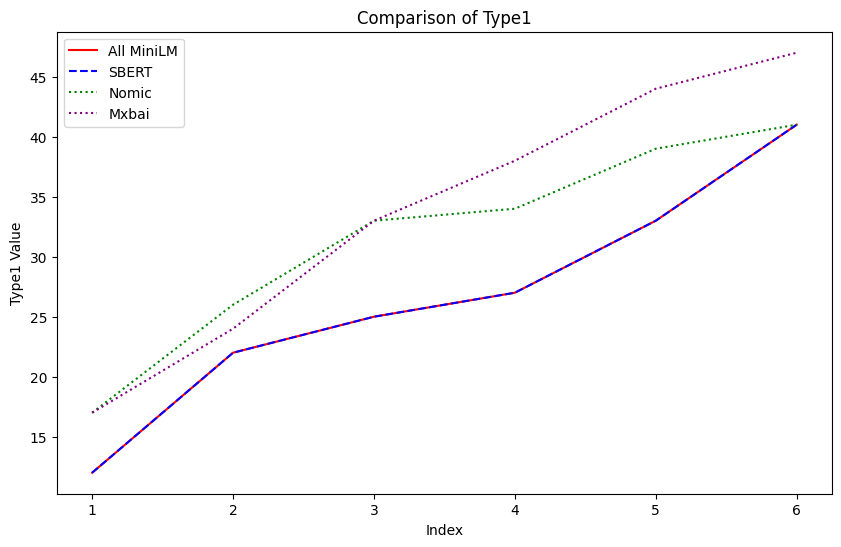

In [48]:
from matplotlib import pyplot as plt

%matplotlib inline
plt.figure(figsize=(10, 6))

# Plot each DataFrame with a different color and label
df_all_minilm_results["Type1"].plot(label="All MiniLM", color="red")
df_sbert["Type1"].plot(label="SBERT", color="blue", linestyle="--")
df_nomic_results["Type1"].plot(label="Nomic", color="green", linestyle=":")
df_mxbai_results["Type1"].plot(label="Mxbai", color="purple", linestyle=":")

# Add legend, title, and labels
plt.legend()
plt.title("Comparison of Type1")
plt.xlabel("Index")
plt.ylabel("Type1 Value")

plt.show()

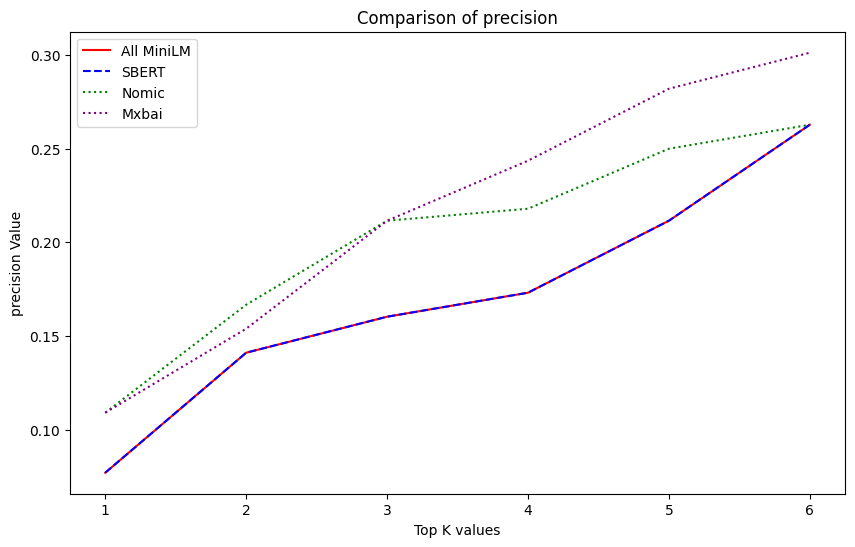

In [49]:
from matplotlib import pyplot as plt

%matplotlib inline
plt.figure(figsize=(10, 6))

# Plot each DataFrame with a different color and label
df_all_minilm_results["precision"].plot(label="All MiniLM", color="red")
df_sbert["precision"].plot(label="SBERT", color="blue", linestyle="--")
df_nomic_results["precision"].plot(label="Nomic", color="green", linestyle=":")
df_mxbai_results["precision"].plot(label="Mxbai", color="purple", linestyle=":")

# Add legend, title, and labels
plt.legend()
plt.title("Comparison of precision")
plt.xlabel("Top K values")
plt.ylabel("precision Value")
# plt.xticks(list(range(1,7)))

plt.show()

In [16]:
df_sbert = pd.read_csv(ROOT_DIR / "test" / "pred_results_sbert.csv")
df_sbert = df_sbert[df_sbert["match_type"] == "Type1"]
df_sbert["target_common"] = (
    df_sbert["target_table_pred"] + "_" + df_sbert["target_column_pred"]
)

In [17]:
df_nomic = pd.read_csv(ROOT_DIR / "test/pred_results_semantic_embedding_nomic.csv")
df_nomic = df_nomic[df_nomic["match_type"] == "Type1"]
df_nomic["target_common"] = (
    df_nomic["target_table_pred"] + "_" + df_nomic["target_column_pred"]
)

In [18]:
df_all_minilm = pd.read_csv(
    ROOT_DIR / "test/pred_results_semantic_embedding_all_minilm.csv"
)
df_all_minilm = df_all_minilm[df_all_minilm["match_type"] == "Type1"]
df_all_minilm["target_common"] = (
    df_all_minilm["target_table_pred"] + "_" + df_all_minilm["target_column_pred"]
)

In [19]:
# No difference Found
set(df_all_minilm["target_common"].unique()) - set(df_sbert["target_common"].unique())

set()

In [50]:
set(df_all_minilm["target_common"].unique()) - set(df_nomic["target_common"].unique())
# df_nomic

{'observation_observation datetime',
 'visit detail_discharge to source value',
 'visit detail_visit detail start datetime'}

In [51]:
set(df_nomic["target_common"].unique()) - set(df_all_minilm["target_common"].unique())

{'condition occurrence_person id',
 'drug exposure_drug exposure start datetime',
 'person_gender source value',
 'procedure occurrence_visit detail id',
 'specimen_person id',
 'specimen_quantity',
 'specimen_specimen type concept id',
 'visit occurrence_admitted from source value'}